In [ ]:
from pathlib import Path
import sys
# Agregar el path del directorio "code"
code_path = Path("../code").resolve()
if str(code_path) not in sys.path:
    sys.path.insert(0, str(code_path))


In [ ]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
#from utils import get_channel
#from CustomTransformers import TimeSeriesFreqRegularization
#from utils import rolling_forecast
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from itertools import product
from TimeSeriesUtils import rolling_forecast

In [27]:
df = pd.read_csv("../datasets/ETH-USD_Open.csv", parse_dates=True, index_col="Datetime")
#df = df.asfreq("T")

In [28]:
df["Price"] = df["Open"]
df.drop(columns=["Open"], inplace=True)

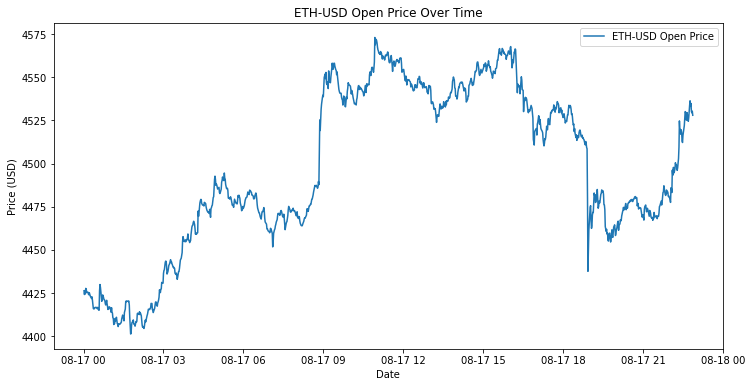

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='ETH-USD Open Price')
plt.title('ETH-USD Open Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Ver valores ¿Es estacionaria?

In [30]:
ADF_result = adfuller(df["Price"])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.6951524852295587
p-value: 0.43361177714170085


No rechazamos la hipótesis nula de que la serie tiene una raíz unitaria y por tanto la serie no es estacionaria. Debemos obtener la diferencia de primer orden. 

In [31]:
df.loc[:,['values_diff']] = df["Price"].diff()
df_diff1 = df.copy()
#Eliminamos el nulo del inicio
df_diff1.dropna(inplace=True)

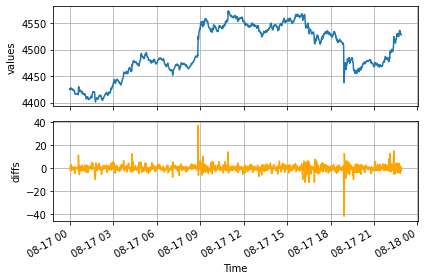

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df["Price"])
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
#ax1.axvspan(450, 500, color='#808080', alpha=0.2)
ax1.grid()
ax2.plot(df['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
ax2.grid()
#ax2.axvspan(449, 498, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()

plt.show()

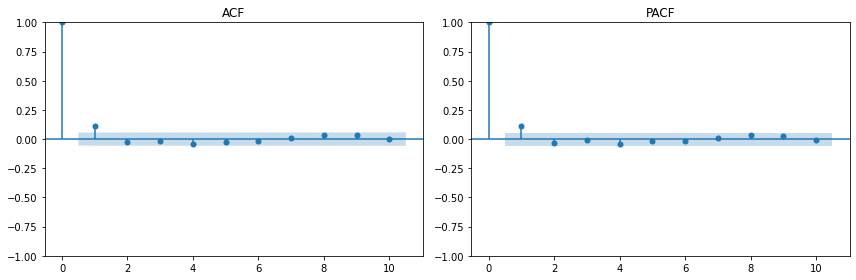

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ACF
plot_acf(df_diff1["values_diff"], ax=axes[0], lags=10, alpha=0.05)
axes[0].set_title("ACF")

# PACF
plot_pacf(df_diff1["values_diff"], ax=axes[1], lags=10, alpha=0.05, method="ywm")
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

Ambos se ven iguales, no hay correlaciones significativas, puede ser un AR(1) o un MA(1) muy débil, no hay dependencias.

Sigamos adelante (Somos difíciles de convencer)

¿Que tal búsqueda exhaustiva?

In [34]:
ps = range(0, 2, 1)    
qs = range(0, 2, 1)
#Producto cartesiano de los valores de p y q
# Esto genera todas las combinaciones posibles de p y q
order_list = list(product(ps, qs))

In [35]:
ldf = df_diff1.copy()
train_len = int(ldf.shape[0]*0.9)
test_len = ldf.shape[0] - train_len
train = ldf[:train_len]
test = ldf[train_len:]
results = []
for p, q in order_list:
    try:
        model = SARIMAX(train['values_diff'], order=(p, 0, q), simple_differencing=False)
        model_fit = model.fit(disp=False)
    except:
        print(f"Error with order ({p}, {q}), skipping...")
        continue
    aic = model_fit.aic
    results.append([(p, q), aic])

c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

Parece que lo mejor es un q=1, media móvil de 1. Restaría analizar los residuos.

In [36]:
result_df = pd.DataFrame(results)
result_df.columns = ['(p,q)', 'AIC']
#Sort in ascending order, lower AIC is better
result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
result_df.loc[:5,:]

,"(p,q)",AIC
0,"(0, 1)",5567.533227
1,"(1, 0)",5568.496139
2,"(1, 1)",5569.237385
3,"(0, 0)",5582.922112


In [38]:
p, q = result_df.loc[0].values[0]
model = SARIMAX(train['values_diff'], order=(p,0,q), simple_differencing=False)
model_fit = model.fit(disp=False)
#print(model_fit.summary())

c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


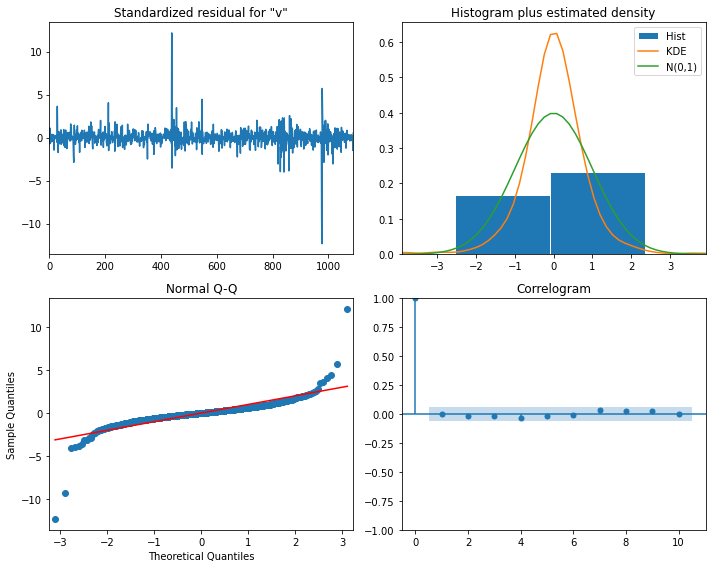

In [45]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

Tanto el QQ como el histograma muestran fallas en los residuos. La curva KDE no se superpone con el histograma

In [43]:
residuos = model_fit.resid
print(residuos.head())

Datetime
2025-08-17 00:02:00+00:00   -2.188477
2025-08-17 00:03:00+00:00    2.579669
2025-08-17 00:04:00+00:00   -2.211864
2025-08-17 00:05:00+00:00    3.417886
2025-08-17 00:06:00+00:00   -0.886091
dtype: float64


¿Le podemos ganar a alguna estrategia ingenua?

In [46]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1
print(f'TRAIN_LEN: {TRAIN_LEN}, HORIZON: {HORIZON}, WINDOW: {WINDOW}')

TRAIN_LEN: 1090, HORIZON: 122, WINDOW: 1


In [47]:
pred_mean       = rolling_forecast(ldf[['values_diff']], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(ldf[['values_diff']], TRAIN_LEN, HORIZON, WINDOW, 'last')
order = (0, 0, 1)
seasonal_order = (0, 0, 0, 0)
pred_ARMA       = rolling_forecast(ldf[['values_diff']], TRAIN_LEN, HORIZON, WINDOW, 'ARMA', order=order, seasonal_order=seasonal_order)

c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

In [48]:
test.loc[:, 'pred_mean']        = pred_mean
test.loc[:, 'pred_last_value']  = pred_last_value
test.loc[:, 'pred_ARMA']        = pred_ARMA

test.head()

C:\Users\pabli\AppData\Local\Temp\ipykernel_6440\2295020119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean']        = pred_mean
C:\Users\pabli\AppData\Local\Temp\ipykernel_6440\2295020119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_value']  = pred_last_value
C:\Users\pabli\AppData\Local\Temp\ipykernel_6440\2295020119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,Price,values_diff,pred_mean,pred_last_value,pred_ARMA
Datetime,,,,,
2025-08-17 20:49:00+00:00,4476.868652,0.437012,0.046012,0.963867,0.202058
2025-08-17 20:50:00+00:00,4473.630859,-3.237793,0.046371,0.437012,0.030332
2025-08-17 20:51:00+00:00,4474.573730,0.942871,0.043363,-3.237793,-0.422138
2025-08-17 20:52:00+00:00,4474.368652,-0.205078,0.044186,0.942871,0.175547
2025-08-17 20:53:00+00:00,4474.156738,-0.211914,0.043958,-0.205078,-0.048961


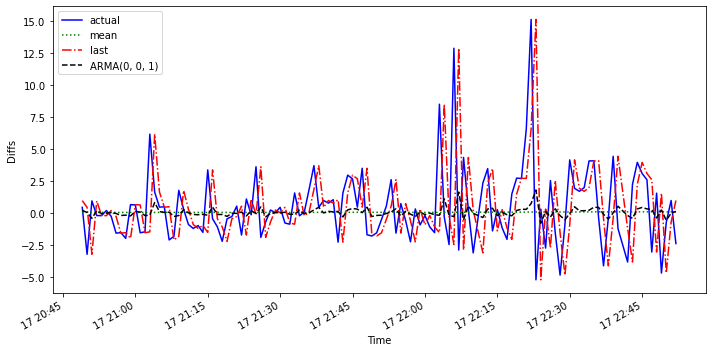

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(df['values'])
ax.plot(test['values_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label=f'ARMA{order}')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Diffs')
#ax.axvspan(947, 998, color='#808080', alpha=0.2)
#ax.set_xlim(920, 999)
#plt.xticks([936, 988],[2018, 2019])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

¿Que modelo dio mejor?

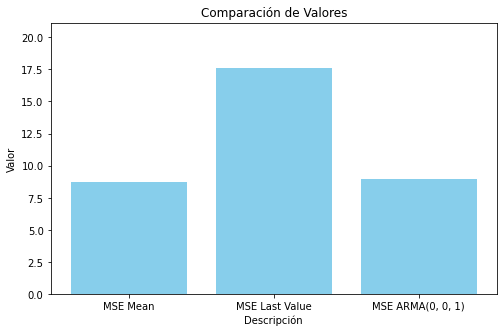

In [50]:
from sklearn.metrics import mean_squared_error
mse_mean    = mean_squared_error(test['values_diff'], test['pred_mean'])
mse_last    = mean_squared_error(test['values_diff'], test['pred_last_value'])
mse_MA      = mean_squared_error(test['values_diff'], test['pred_ARMA'])

df_comm = pd.DataFrame({
    'Descripción': ['MSE Mean', 'MSE Last Value', f'MSE ARMA{order}'],
    'Valor': [mse_mean, mse_last, mse_MA]
})

plt.figure(figsize=(8, 5))
plt.bar(df_comm['Descripción'], df_comm['Valor'], color='skyblue')

plt.title('Comparación de Valores')
plt.xlabel('Descripción')
plt.ylabel('Valor')
plt.ylim(0, max(df_comm['Valor']) * 1.2)  # margen superior
plt.show()

No, ni siquiera eso, la media dia mejor resultado. 